In [0]:
# ============================================================
# 🚄 USE CASE 4: Complaint Probability Prediction (IRCTC)
# ============================================================
# Goal:
# Predict whether a customer's review represents a complaint 
# (for example, refund issues, app failures, poor service) or not.
#
# Why this matters:
# Automatically identifying complaint-type reviews allows IRCTC 
# to prioritize and address critical issues quickly.
#
# Reusing SAME pipeline from previous use cases:
# Tokenization → Stopword Removal → TF-IDF → Logistic Regression
# ============================================================

# ------------------------------------------------------------
# 🧩 Step 1: Import Libraries & Initialize Spark
# ------------------------------------------------------------
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, lower, regexp_replace, trim, when, udf
from pyspark.sql.types import IntegerType
from pyspark.ml.feature import Tokenizer, StopWordsRemover, HashingTF, IDF
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import matplotlib.pyplot as plt
import pandas as pd

In [0]:
# Initialize Spark Session
spark = SparkSession.builder.appName("IRCTC_Complaint_Prediction").getOrCreate()
print("✅ Spark session started successfully!")

✅ Spark session started successfully!


In [0]:
# ------------------------------------------------------------
# 📂 Step 2: Load Dataset
# ------------------------------------------------------------
file_path = "/Volumes/workspace/default/dataset2/irctc_reviews.csv"
df = spark.read.option("header", "true").csv(file_path)
print(f"✅ Dataset Loaded Successfully | Total Rows: {df.count()}")
df.show(5, truncate=False)

✅ Dataset Loaded Successfully | Total Rows: 1000
+------------------------------------+-------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----+
|reviewId                            |userName     |content                                                                                                                                                                                                                                                                                                                                                                |score|
+------------------------------------+-------------+-------------------------------------------------------------

In [0]:
# ------------------------------------------------------------
# 🧼 Step 3: Data Cleaning & Preprocessing
# ------------------------------------------------------------
def safe_to_int(x):
    try:
        return int(x)
    except:
        return None

safe_to_int_udf = udf(safe_to_int, IntegerType())
df = df.withColumn("score_int", safe_to_int_udf(trim(col("score"))))
df = df.filter(col("score_int").isNotNull() & col("content").isNotNull())

# Clean and preprocess text
df = df.withColumn("review", lower(regexp_replace(trim(col("content")), "[^a-zA-Z\\s]", "")))


In [0]:
# ------------------------------------------------------------
# 🎯 Step 4: Create Binary Complaint Labels
# ------------------------------------------------------------
# Label = 1 if the review likely represents a complaint (score ≤ 2)
# Label = 0 if it represents a normal/non-complaint review
df = df.withColumn(
    "label",
    when(col("score_int") <= 2, 1).otherwise(0)
)
print("✅ Complaint labels created successfully!")
df.select("review", "score_int", "label").show(5, truncate=False)

✅ Complaint labels created successfully!
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------+-----+
|review                                                                                                                                                                                                                                                                                                                                                              |score_int|label|
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [0]:
# ------------------------------------------------------------
# 🧠 Step 5: Reuse NLP Pipeline (Same as previous cases)
# ------------------------------------------------------------
tokenizer = Tokenizer(inputCol="review", outputCol="words")
remover = StopWordsRemover(inputCol="words", outputCol="filtered_words")
hashingTF = HashingTF(inputCol="filtered_words", outputCol="rawFeatures", numFeatures=5000)
idf = IDF(inputCol="rawFeatures", outputCol="features")

lr = LogisticRegression(featuresCol="features", labelCol="label", maxIter=20)
pipeline = Pipeline(stages=[tokenizer, remover, hashingTF, idf, lr])
print("✅ Reusable NLP + ML Pipeline ready!")

✅ Reusable NLP + ML Pipeline ready!


In [0]:
# ------------------------------------------------------------
# 🧩 Step 6: Split Data and Train Model
# ------------------------------------------------------------
train_df, test_df = df.randomSplit([0.8, 0.2], seed=42)
model = pipeline.fit(train_df)
predictions = model.transform(test_df)
print("✅ Complaint prediction model trained successfully!")

✅ Complaint prediction model trained successfully!


In [0]:
# ------------------------------------------------------------
# 📈 Step 7: Evaluate Model Performance
# ------------------------------------------------------------
evaluator = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="accuracy"
)
accuracy = evaluator.evaluate(predictions)
print(f"✅ Model Accuracy: {accuracy * 100:.2f}%")

✅ Model Accuracy: 81.37%


In [0]:
# ------------------------------------------------------------
# 🔮 Step 8: Test Complaint Prediction on New Samples
# ------------------------------------------------------------
sample_data = [
    ("refund not received for my cancelled ticket",),
    ("great app and easy booking process",),
    ("train was clean and comfortable",),
    ("worst experience ever, app keeps crashing",)
]

sample_df = spark.createDataFrame(sample_data, ["review"])
sample_predictions = model.transform(sample_df)
sample_predictions.select("review", "prediction").show(truncate=False)

print("✅ Sample predictions generated successfully!")

+-------------------------------------------+----------+
|review                                     |prediction|
+-------------------------------------------+----------+
|refund not received for my cancelled ticket|0.0       |
|great app and easy booking process         |0.0       |
|train was clean and comfortable            |1.0       |
|worst experience ever, app keeps crashing  |1.0       |
+-------------------------------------------+----------+

✅ Sample predictions generated successfully!


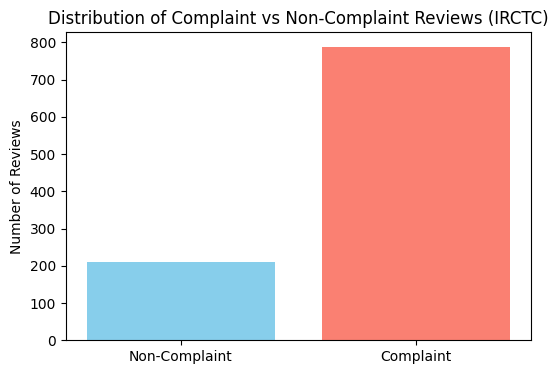

In [0]:
# ------------------------------------------------------------
# 📊 Step 9: Visualize Complaint Distribution
# ------------------------------------------------------------
from pyspark.sql.functions import count

label_counts = (
    df.groupBy("label")
    .agg(count("*").alias("count"))
    .orderBy("label")
)
label_pd = label_counts.toPandas()

plt.figure(figsize=(6,4))
plt.bar(["Non-Complaint", "Complaint"], label_pd["count"], color=["skyblue","salmon"])
plt.title("Distribution of Complaint vs Non-Complaint Reviews (IRCTC)")
plt.ylabel("Number of Reviews")
plt.show()

In [0]:
# ------------------------------------------------------------
# 💬 Step 10: Insights Summary
# ------------------------------------------------------------
total = label_pd["count"].sum()
complaints = int(label_pd[label_pd["label"] == 1]["count"])
normal = int(label_pd[label_pd["label"] == 0]["count"])
print("\n🔍 Insights Summary:")
print(f"Total Reviews: {total}")
print(f"Complaints: {complaints} ({complaints/total*100:.2f}%)")
print(f"Non-Complaints: {normal} ({normal/total*100:.2f}%)")
print(f"Model Accuracy: {accuracy*100:.2f}%")
print("\n✅ Use Case 4 executed successfully — Complaint Probability Prediction completed!")



🔍 Insights Summary:
Total Reviews: 999
Complaints: 788 (78.88%)
Non-Complaints: 211 (21.12%)
Model Accuracy: 81.37%

✅ Use Case 4 executed successfully — Complaint Probability Prediction completed!


/home/spark-316b3c69-8409-47f0-8c8c-e1/.ipykernel/2481/command-5285018378278113-3804419615:5: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  complaints = int(label_pd[label_pd["label"] == 1]["count"])
/home/spark-316b3c69-8409-47f0-8c8c-e1/.ipykernel/2481/command-5285018378278113-3804419615:6: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  normal = int(label_pd[label_pd["label"] == 0]["count"])


In [0]:
# ------------------------------------------------------------
# 💾 Step 11: Save Complaint Predictions
# ------------------------------------------------------------
output_df = predictions.select("review", "prediction")
output_path = "/Workspace/exports/IRCTC_Complaint_Prediction_Results.csv"
output_df.toPandas().to_csv(output_path, index=False)
print(f"📁 Complaint prediction results saved at: {output_path}")

📁 Complaint prediction results saved at: /Workspace/exports/IRCTC_Complaint_Prediction_Results.csv
